In [1]:
import numpy as np
from datasets import load_dataset
import torch
from torch import nn
import pandas as pd
import transformers
from transformers import RobertaTokenizerFast
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import Dataset
from transformers import TrainingArguments,Trainer
import random
import matplotlib.pyplot as plt

In [2]:
#import question answering glue dataset (1%)
train = load_dataset("glue", "qnli",split = 'train[:1%]')
test = load_dataset("glue", "qnli",split = 'test[:1%]')
val = load_dataset("glue", "qnli",split = 'validation[:1%]')


Reusing dataset glue (/Users/sagar/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/Users/sagar/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/Users/sagar/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [3]:
#combine sentence/question into a single input
x_train = []
y_train = train["label"]

for i in range(0,len(train["sentence"])):
    x = train["sentence"][i] +" "+ train["question"][i]
    x_train.append(x)
    
x_test = []
y_test = test["label"]

for i in range(0,len(test["sentence"])):
    x = test["sentence"][i] +" "+ test["question"][i]
    x_test.append(x)


x_val = []
y_val = val["label"]

for i in range(0,len(val["sentence"])):
    x = val["sentence"][i] +" "+ val["question"][i]
    x_val.append(x)

In [4]:
df_train = pd.DataFrame()
df_train["Text"] = x_train
df_train["Label"] = y_train

df_test = pd.DataFrame()
df_test["Text"] = x_test
df_test["Label"] = y_test


df_val = pd.DataFrame()
df_val["Text"] = x_val
df_val["Label"] = y_val
df_train

,Text,Label
0,Unlike the two seasons before it and most of t...,1
1,"When MANPADS is operated by specialists, batte...",1
2,He bases this interpretation on the fact that ...,0
3,"On 31 December 1853, the Ottoman forces at Cal...",0
4,London contains four World Heritage Sites: the...,1
...,...,...
1042,The universe cannot exist as it appears if the...,1
1043,The cemetery is known for its grand Egyptian R...,1
1044,Germany was rapidly rising as a military and i...,1
1045,The Nazis used propaganda to great effect to s...,0


In [5]:
def encode_data(df, text_column, tokenizer, max_seq_length=128):
    tokenized = tokenizer(list(df[text_column]), truncation=True,padding="max_length", max_length=max_seq_length)

    input_ids = torch.LongTensor(tokenized["input_ids"])
    attention_mask = torch.LongTensor(tokenized["attention_mask"])
    return input_ids,attention_mask

def extract_labels(dataset):
    labels = list(dataset["Label"])
    return labels

class Dataset(Dataset):
    def __init__(self, dataframe, text_column, tokenizer, max_seq_length=256):
        self.encoded_data = encode_data(dataframe,text_column, tokenizer,max_seq_length)
        self.label_list = extract_labels(dataframe)

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, i):
        input_ids,attention_mask = self.encoded_data
        labels = self.label_list
        dict_i = {}
        dict_i["input_ids"] = input_ids[i]
        dict_i["attention_mask"] = attention_mask[i]
        dict_i["label"] = labels[i]
        return dict_i
    
def model_init():
    return RobertaForSequenceClassification.from_pretrained("roberta-base")

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)
    dic = {}
    accuracy = accuracy_score(labels, preds)
    return dic

def model_init():
    return RobertaForSequenceClassification.from_pretrained("roberta-base")



In [6]:
text = "This is a test"
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
tokenizer(text)

{'input_ids': [0, 713, 16, 10, 1296, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [7]:
text = "!"
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
tokenizer(text)

{'input_ids': [0, 328, 2], 'attention_mask': [1, 1, 1]}

In [8]:
#convert dataframes to hugging face datasets
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

train_dataset = Dataset(df_train,"Text", tokenizer)
test_dataset = Dataset(df_test,"Text", tokenizer)
val_dataset = Dataset(df_val,"Text", tokenizer)


In [ ]:
training_args = TrainingArguments(num_train_epochs = 3,  
                                  per_device_train_batch_size = 8, 
                                  output_dir="results",
                                logging_steps=50,
                                eval_steps=50,
)

trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    model_init=model_init,   
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model("models/test")

In [7]:
model = RobertaForSequenceClassification.from_pretrained("models/5-6")
trainer = Trainer(model=model)


In [8]:
clean_preds = trainer.predict(val_dataset).predictions
clean_preds = np.argmax(clean_preds, axis=-1)
acc = accuracy_score(df_val.Label, clean_preds)
print(f"Accuracy on clean dataset {acc}")

***** Running Prediction *****
  Num examples = 55
  Batch size = 8


Accuracy on clean dataset 0.8181818181818182


In [9]:
import nltk
nltk.download('averaged_perceptron_tagger')

def get_keys_around(key):
    try:
        lines = 'qwertyuiop', 'asdfghjkl', 'zxcvbnm'
        line_index, index = [(i, l.find(key)) for i, l in enumerate(lines) if key in l][0]
        lines = lines[line_index-1: line_index+2] if line_index else lines[0: 2]
        return [
            line[index + i] for line in lines for i in [-1, 0, 1]
            if len(line) > index + i and line[index + i] != key and index + i >= 0]
    except:
        return [key]

#function to replace random character in a word with a nearby key
def get_noisy_word(word): 
    i = np.random.randint(0,len(word))
    noisy_word = word
    noisy_char = get_keys_around(word[i].lower())
    noisy_char = noisy_char[np.random.randint(0,len(noisy_char))]
    if word[i].isupper():
        noisy_char = noisy_char.upper()
    noisy_word = word[:i] + noisy_char + word[i + 1:]

    return noisy_word

def selective_replace(sentence, word, noisy_word, rev):
    
    if rev == True:
        sentence.reverse()
    
    new_sentence = sentence
    i = new_sentence.index(word)
    new_sentence[i] = noisy_word
    if rev == True:
        new_sentence.reverse()

    return new_sentence

def add_noise_POS_max_words(text, pos_types, all_POS = False, max_words =1000, noise_prob = 1, start_last = True):
    
    text = nltk.word_tokenize(text)
    noisy_text = text
    results = nltk.pos_tag(text)
    
    if start_last:
        #Add noisy from the end to start of the sentence
        results.reverse()
        
    #Count total number of applicable POS. 
    total_pos = 0
    if all_POS:
        total_pos = len(results)
    else:
        for res in results:
            if res[1] in pos_types:
                total_pos = total_pos + 1

                
    update_count = 0
    for res in results:
        #Stop if already added enough noise 
        if  total_pos == 0:
            break
        
        #Add noise to POS
        if (res[1] in pos_types or all_POS) and update_count <max_words :
            
            if random.random() < noise_prob:
                word = res[0]
                noisy_word = get_noisy_word(word)
                noisy_text = selective_replace(noisy_text, word, noisy_word, start_last)
                
        update_count = update_count +1            
    
    res = ' '.join(noisy_text)
    return res


def get_POS_count(text, POS_list):
    text = nltk.word_tokenize(text)
    results = nltk.pos_tag(text)
    count = 0
    for res in results:        
        if (res[1] in POS_list):
            count = count + 1        
    return count

text = df_val.iloc[0].Text
noisy_text = add_noise_POS_max_words(text, pos_types=[], all_POS=True, max_words = 5,noise_prob = 0.5)
print(text)
print(noisy_text)

As of that day, the new constitution heralding the Second Republic came into force. What came into force after the new constitution was herald?
As of that day , the new constitution heralding the Second Republic came into force . What came into force after the new constitktion wae herxld ?


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sagar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [15]:
verbs = ["VB", "VBD","VBG","VBN","VBP","VBZ", 'MD']
mid = ["JJ","JJR","JJS","IN","TO"]
nouns = ["NN","NNS"]
function = ["WDT","WP","WRB","DT","PDT","PRP","PRP$", "TH"]
content = ["VB", "VBD","VBG","VBN","VBP","VBZ", 'MD',"NN","NNS"] 

# POS1 = ["WDT","WP","WRB","MD","DT","PDT","PRP","PRP$", "TH"]
# POS2 = ["JJ","JJR","JJS","IN", "TO"]
# POS3 = ["VB","VBG","VBD","VBN","VBP","VBZ"]
all_POS = [verbs, mid,nouns,function,content]
get_POS_count(text, verbs)

5

In [16]:
results = pd.DataFrame()
results

""


In [17]:
#get accuracy baseline
start_lst = [True, False]
noise_percentages = [0.25, 0.5, 0.75, 0.9]
df_val["noisy_text_random"] = ""
df_val["noisy_text_POS"] = ""

for pos in all_POS:
    for start in start_lst:
        for percent in noise_percentages:
            for i, row in df_val.iterrows():
                clean = row["Text"]
                count = get_POS_count(text,pos)
                noisy_pos = add_noise_POS_max_words(clean, pos,False,count,percent,start)
                noisy_random = add_noise_POS_max_words(clean, [],True,count,percent,start)
                df_val.at[i, 'noisy_text_POS'] = noisy_pos
                df_val.at[i, 'noisy_text_random'] =noisy_random

            val_dataset_noisy = Dataset(df_val,"noisy_text_random", tokenizer)
            preds = trainer.predict(val_dataset_noisy).predictions
            preds = np.argmax(preds, axis=-1)
            acc_random = accuracy_score(df_val.Label, preds)
            
            val_dataset_noisy = Dataset(df_val,"noisy_text_POS", tokenizer)
            preds = trainer.predict(val_dataset_noisy).predictions
            preds = np.argmax(preds, axis=-1)
            acc_pos = accuracy_score(df_val.Label, preds)

            
            vals = {"POS": pos, "Noise_Percent":percent, "Start_Last": start, "Accuracy_Random": acc_random, "Accuracy_POS":acc_pos}
            print(vals)
            results = results.append(vals,ignore_index=True)

***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'], 'Noise_Percent': 0.25, 'Start_Last': True, 'Accuracy_Random': 0.7454545454545455, 'Accuracy_POS': 0.7818181818181819}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'], 'Noise_Percent': 0.5, 'Start_Last': True, 'Accuracy_Random': 0.7818181818181819, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'], 'Noise_Percent': 0.75, 'Start_Last': True, 'Accuracy_Random': 0.7818181818181819, 'Accuracy_POS': 0.8181818181818182}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'], 'Noise_Percent': 0.9, 'Start_Last': True, 'Accuracy_Random': 0.7090909090909091, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'], 'Noise_Percent': 0.25, 'Start_Last': False, 'Accuracy_Random': 0.8363636363636363, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'], 'Noise_Percent': 0.5, 'Start_Last': False, 'Accuracy_Random': 0.8, 'Accuracy_POS': 0.8181818181818182}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'], 'Noise_Percent': 0.75, 'Start_Last': False, 'Accuracy_Random': 0.7636363636363637, 'Accuracy_POS': 0.7818181818181819}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'], 'Noise_Percent': 0.9, 'Start_Last': False, 'Accuracy_Random': 0.7272727272727273, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['JJ', 'JJR', 'JJS', 'IN', 'TO'], 'Noise_Percent': 0.25, 'Start_Last': True, 'Accuracy_Random': 0.8, 'Accuracy_POS': 0.7818181818181819}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['JJ', 'JJR', 'JJS', 'IN', 'TO'], 'Noise_Percent': 0.5, 'Start_Last': True, 'Accuracy_Random': 0.7454545454545455, 'Accuracy_POS': 0.7636363636363637}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['JJ', 'JJR', 'JJS', 'IN', 'TO'], 'Noise_Percent': 0.75, 'Start_Last': True, 'Accuracy_Random': 0.6909090909090909, 'Accuracy_POS': 0.7636363636363637}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['JJ', 'JJR', 'JJS', 'IN', 'TO'], 'Noise_Percent': 0.9, 'Start_Last': True, 'Accuracy_Random': 0.6, 'Accuracy_POS': 0.7636363636363637}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['JJ', 'JJR', 'JJS', 'IN', 'TO'], 'Noise_Percent': 0.25, 'Start_Last': False, 'Accuracy_Random': 0.7818181818181819, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['JJ', 'JJR', 'JJS', 'IN', 'TO'], 'Noise_Percent': 0.5, 'Start_Last': False, 'Accuracy_Random': 0.8, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['JJ', 'JJR', 'JJS', 'IN', 'TO'], 'Noise_Percent': 0.75, 'Start_Last': False, 'Accuracy_Random': 0.7090909090909091, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['JJ', 'JJR', 'JJS', 'IN', 'TO'], 'Noise_Percent': 0.9, 'Start_Last': False, 'Accuracy_Random': 0.7636363636363637, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['NN', 'NNS'], 'Noise_Percent': 0.25, 'Start_Last': True, 'Accuracy_Random': 0.7636363636363637, 'Accuracy_POS': 0.8181818181818182}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['NN', 'NNS'], 'Noise_Percent': 0.5, 'Start_Last': True, 'Accuracy_Random': 0.7818181818181819, 'Accuracy_POS': 0.7818181818181819}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['NN', 'NNS'], 'Noise_Percent': 0.75, 'Start_Last': True, 'Accuracy_Random': 0.7272727272727273, 'Accuracy_POS': 0.7454545454545455}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['NN', 'NNS'], 'Noise_Percent': 0.9, 'Start_Last': True, 'Accuracy_Random': 0.6909090909090909, 'Accuracy_POS': 0.7272727272727273}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['NN', 'NNS'], 'Noise_Percent': 0.25, 'Start_Last': False, 'Accuracy_Random': 0.8181818181818182, 'Accuracy_POS': 0.7636363636363637}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['NN', 'NNS'], 'Noise_Percent': 0.5, 'Start_Last': False, 'Accuracy_Random': 0.7636363636363637, 'Accuracy_POS': 0.7818181818181819}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['NN', 'NNS'], 'Noise_Percent': 0.75, 'Start_Last': False, 'Accuracy_Random': 0.7272727272727273, 'Accuracy_POS': 0.7636363636363637}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['NN', 'NNS'], 'Noise_Percent': 0.9, 'Start_Last': False, 'Accuracy_Random': 0.7818181818181819, 'Accuracy_POS': 0.7818181818181819}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['WDT', 'WP', 'WRB', 'DT', 'PDT', 'PRP', 'PRP$', 'TH'], 'Noise_Percent': 0.25, 'Start_Last': True, 'Accuracy_Random': 0.7636363636363637, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['WDT', 'WP', 'WRB', 'DT', 'PDT', 'PRP', 'PRP$', 'TH'], 'Noise_Percent': 0.5, 'Start_Last': True, 'Accuracy_Random': 0.8, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['WDT', 'WP', 'WRB', 'DT', 'PDT', 'PRP', 'PRP$', 'TH'], 'Noise_Percent': 0.75, 'Start_Last': True, 'Accuracy_Random': 0.7636363636363637, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['WDT', 'WP', 'WRB', 'DT', 'PDT', 'PRP', 'PRP$', 'TH'], 'Noise_Percent': 0.9, 'Start_Last': True, 'Accuracy_Random': 0.6909090909090909, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['WDT', 'WP', 'WRB', 'DT', 'PDT', 'PRP', 'PRP$', 'TH'], 'Noise_Percent': 0.25, 'Start_Last': False, 'Accuracy_Random': 0.8181818181818182, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['WDT', 'WP', 'WRB', 'DT', 'PDT', 'PRP', 'PRP$', 'TH'], 'Noise_Percent': 0.5, 'Start_Last': False, 'Accuracy_Random': 0.8181818181818182, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['WDT', 'WP', 'WRB', 'DT', 'PDT', 'PRP', 'PRP$', 'TH'], 'Noise_Percent': 0.75, 'Start_Last': False, 'Accuracy_Random': 0.8, 'Accuracy_POS': 0.8}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['WDT', 'WP', 'WRB', 'DT', 'PDT', 'PRP', 'PRP$', 'TH'], 'Noise_Percent': 0.9, 'Start_Last': False, 'Accuracy_Random': 0.7636363636363637, 'Accuracy_POS': 0.8181818181818182}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD', 'NN', 'NNS'], 'Noise_Percent': 0.25, 'Start_Last': True, 'Accuracy_Random': 0.7454545454545455, 'Accuracy_POS': 0.8181818181818182}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD', 'NN', 'NNS'], 'Noise_Percent': 0.5, 'Start_Last': True, 'Accuracy_Random': 0.7090909090909091, 'Accuracy_POS': 0.7454545454545455}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD', 'NN', 'NNS'], 'Noise_Percent': 0.75, 'Start_Last': True, 'Accuracy_Random': 0.6181818181818182, 'Accuracy_POS': 0.7090909090909091}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD', 'NN', 'NNS'], 'Noise_Percent': 0.9, 'Start_Last': True, 'Accuracy_Random': 0.6181818181818182, 'Accuracy_POS': 0.6727272727272727}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD', 'NN', 'NNS'], 'Noise_Percent': 0.25, 'Start_Last': False, 'Accuracy_Random': 0.8181818181818182, 'Accuracy_POS': 0.7818181818181819}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD', 'NN', 'NNS'], 'Noise_Percent': 0.5, 'Start_Last': False, 'Accuracy_Random': 0.7454545454545455, 'Accuracy_POS': 0.7818181818181819}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD', 'NN', 'NNS'], 'Noise_Percent': 0.75, 'Start_Last': False, 'Accuracy_Random': 0.7818181818181819, 'Accuracy_POS': 0.7818181818181819}


***** Running Prediction *****
  Num examples = 55
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8


{'POS': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD', 'NN', 'NNS'], 'Noise_Percent': 0.9, 'Start_Last': False, 'Accuracy_Random': 0.7090909090909091, 'Accuracy_POS': 0.7454545454545455}


In [18]:
results_sorted = results.sort_values(by="Accuracy_Random", ascending = False)
results_sorted

,Accuracy_POS,Accuracy_Random,Noise_Percent,POS,Start_Last
4,0.800000,0.836364,0.25,"[VB, VBD, VBG, VBN, VBP, VBZ, MD]",0.0
20,0.763636,0.818182,0.25,"[NN, NNS]",0.0
28,0.800000,0.818182,0.25,"[WDT, WP, WRB, DT, PDT, PRP, PRP$, TH]",0.0
29,0.800000,0.818182,0.50,"[WDT, WP, WRB, DT, PDT, PRP, PRP$, TH]",0.0
36,0.781818,0.818182,0.25,"[VB, VBD, VBG, VBN, VBP, VBZ, MD, NN, NNS]",0.0
13,0.800000,0.800000,0.50,"[JJ, JJR, JJS, IN, TO]",0.0
5,0.818182,0.800000,0.50,"[VB, VBD, VBG, VBN, VBP, VBZ, MD]",0.0
8,0.781818,0.800000,0.25,"[JJ, JJR, JJS, IN, TO]",1.0
30,0.800000,0.800000,0.75,"[WDT, WP, WRB, DT, PDT, PRP, PRP$, TH]",0.0
25,0.800000,0.800000,0.50,"[WDT, WP, WRB, DT, PDT, PRP, PRP$, TH]",1.0


In [19]:
results_sorted.to_csv("performance/results_max_words_v4.csv")

In [20]:
results_sorted.to_pickle("performance/results_max_words_v4.pkl")  

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [82]:
data = results_sorted
data["POS"] = data["POS"].astype('str')

In [85]:
verbs = ["VB", "VBD","VBG","VBN","VBP","VBZ", 'MD']
mid = ["JJ","JJR","JJS","IN","TO"]
nouns = ["NN","NNS"]
function = ["WDT","WP","WRB","DT","PDT","PRP","PRP$", "TH"]
content = ["VB", "VBD","VBG","VBN","VBP","VBZ", 'MD',"NN","NNS"] 
pos_titles = {}
pos_titles["ALL"] = "Random"
pos_titles[str(verbs)] = "verbs"
pos_titles[str(mid)] = "mid"
pos_titles[str(nouns)] = "nouns"
pos_titles[str(function)] = "function"
pos_titles[str(content)] = "content"


[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Noise Probaiblity'),
 Text(0.5, 1.0, 'Average Accuracy')]

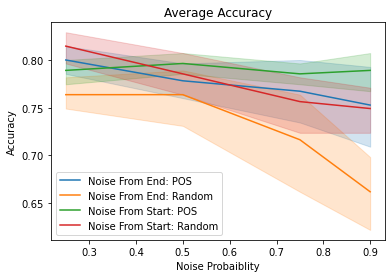

In [86]:
temp = data[data.Start_Last == True]
p1 = sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = "Noise From End: POS")
p1 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "Noise From End: Random")

temp = data[data.Start_Last == False]
p1 =sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = "Noise From Start: POS")
p1 =sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "Noise From Start: Random")

p1.set( xlabel = "Noise Probaiblity", ylabel = "Accuracy", title = "Average Accuracy")

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Noise Probaiblity'),
 Text(0.5, 1.0, 'Accuracy of Noisy Verbs and Random Words')]

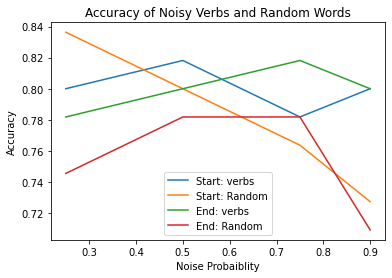

In [96]:
temp = data[(data.POS == str(verbs)) & (data.Start_Last == False)]
p2 = sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = str(f"Start: {pos_titles[str(verbs)]}"))
p2 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "Start: Random")
temp = data[(data.POS == str(verbs)) & (data.Start_Last == True)]
p2 =sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = str(f"End: {pos_titles[str(verbs)]}"))
p2 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "End: Random")
p2.set( xlabel = "Noise Probaiblity", ylabel = "Accuracy", title = "Accuracy of Noisy Verbs and Random Words")

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Noise Probaiblity'),
 Text(0.5, 1.0, 'Accuracy of Noisy Mid and Random Words')]

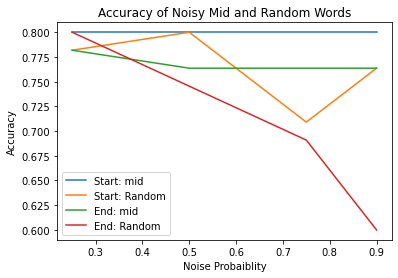

In [97]:
temp = data[(data.POS == str(mid)) & (data.Start_Last == False)]
p3 = sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = str(f"Start: {pos_titles[str(mid)]}"))
p3 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "Start: Random")
temp = data[(data.POS == str(mid)) & (data.Start_Last == True)]
p3 =sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = str(f"End: {pos_titles[str(mid)]}"))
p3 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "End: Random")
p3.set( xlabel = "Noise Probaiblity", ylabel = "Accuracy", title = "Accuracy of Noisy Mid and Random Words")

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Noise Probaiblity'),
 Text(0.5, 1.0, 'Accuracy of Noisy Nouns and Random Words')]

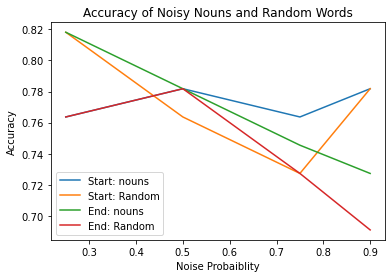

In [98]:
temp = data[(data.POS == str(nouns)) & (data.Start_Last == False)]
p4 = sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = str(f"Start: {pos_titles[str(nouns)]}"))
p4 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "Start: Random")
temp = data[(data.POS == str(nouns)) & (data.Start_Last == True)]
p4 =sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = str(f"End: {pos_titles[str(nouns)]}"))
p4 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "End: Random")
p4.set( xlabel = "Noise Probaiblity", ylabel = "Accuracy", title = "Accuracy of Noisy Nouns and Random Words")

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Noise Probaiblity'),
 Text(0.5, 1.0, 'Accuracy of Noisy Function and Random Words')]

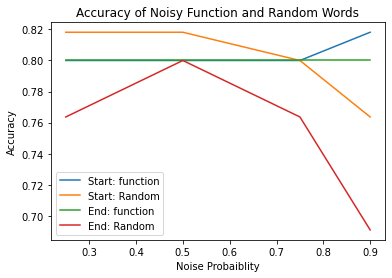

In [99]:
temp = data[(data.POS == str(function)) & (data.Start_Last == False)]
p5 = sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = str(f"Start: {pos_titles[str(function)]}"))
p5 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "Start: Random")
temp = data[(data.POS == str(function)) & (data.Start_Last == True)]
p5 =sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = str(f"End: {pos_titles[str(function)]}"))
p5 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "End: Random")
p5.set( xlabel = "Noise Probaiblity", ylabel = "Accuracy", title = "Accuracy of Noisy Function and Random Words")

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Noise Probaiblity'),
 Text(0.5, 1.0, 'Accuracy of Noisy Content and Random Words')]

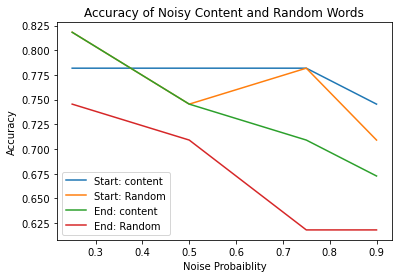

In [100]:
temp = data[(data.POS == str(content)) & (data.Start_Last == False)]
p5 = sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = str(f"Start: {pos_titles[str(content)]}"))
p5 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "Start: Random")
temp = data[(data.POS == str(content)) & (data.Start_Last == True)]
p5 =sns.lineplot(x="Noise_Percent", y="Accuracy_POS", data=temp, Label = str(f"End: {pos_titles[str(content)]}"))
p5 = sns.lineplot(x="Noise_Percent", y="Accuracy_Random", data=temp, Label = "End: Random")
p5.set( xlabel = "Noise Probaiblity", ylabel = "Accuracy", title = "Accuracy of Noisy Content and Random Words")